# Data Prep / Setup

In [2]:
!pip install plotnine
!pip install xgboost

Keyring is skipped due to an exception: 'keyring.backends'
Keyring is skipped due to an exception: 'keyring.backends'


In [3]:
import pandas as pd
import numpy as np
import collections
import plotnine
from plotnine import *
import os
import ast
import random
import statsmodels.api as statsm
import pylab as py
import pickle
import xgboost

In [4]:
pc01_filtered_path = "../../data/PC-01.csv"
pc01_dataset = pd.read_csv(pc01_filtered_path)
pc01_dataset = pc01_dataset.dropna(subset = ['lag1'])
pc01_dataset['y_quarter'] = pc01_dataset['year'].astype(str) + 'Q' + pc01_dataset['quarter'].astype(str)
pc01_dataset

,provider_id,score,lag1,lag2,year,quarter,lag_diff,prov_mean,prov_mean_diff,y_quarter
1,100001,4.0,2.0,NaN,2017,2,2.0,2.000000,2.000000,2017Q2
2,100001,3.0,4.0,2.0,2017,3,-1.0,3.000000,0.000000,2017Q3
3,100001,3.0,3.0,4.0,2017,4,0.0,3.000000,0.000000,2017Q4
4,100001,2.0,3.0,3.0,2018,1,-1.0,3.000000,-1.000000,2018Q1
5,100001,3.0,2.0,3.0,2018,3,1.0,2.800000,0.200000,2018Q3
...,...,...,...,...,...,...,...,...,...,...
32870,90011,5.0,3.0,3.0,2015,3,2.0,2.333333,2.666667,2015Q3
32871,90011,4.0,5.0,3.0,2015,4,-1.0,3.000000,1.000000,2015Q4
32872,90011,4.0,4.0,5.0,2016,1,0.0,3.200000,0.800000,2016Q1
32873,90011,4.0,4.0,4.0,2016,2,0.0,3.333333,0.666667,2016Q2


In [5]:
xgbr_model_path = './xgboost-regression/xgbr_model_final.pkl'
iforest_model_path = './isolation-forest/iforest_model_final.pkl'
ensemble_model_path = './xgbr-ensemble/ensemble_model_final.pkl'
ensemble_model_final = pickle.load(open(ensemble_model_path, 'rb'))

In [6]:
def load_and_predict_xgbr(model_file, modeling_dataset, target, threshold):
    xgbr_model = pickle.load(open(model_file, 'rb'))
    scores = xgbr_model.predict(modeling_dataset)
    prediction = abs(target - scores) > threshold
    
    return scores, prediction

In [7]:
def load_and_predict_iforest(model_file, modeling_dataset, threshold): 
    if_model = pickle.load(open(model_file, 'rb'))
    scores = if_model.score_samples(modeling_dataset) * -1
    prediction = scores > threshold

    return scores, prediction

In [8]:
xgbr_scores, xgbr_prediction =\
    load_and_predict_xgbr(xgbr_model_path,
                          pc01_dataset[['lag1','prov_mean', 'year', 'quarter']],
                          pc01_dataset['score'],
                          5)

In [9]:
iforest_scores, iforest_prediction =\
    load_and_predict_iforest(iforest_model_path,
                          pc01_dataset[['lag_diff','prov_mean_diff']],
                          .52)

In [10]:
xgb_pc01_dataset = pc01_dataset.copy()[['score','y_quarter','provider_id','prov_mean','lag_diff','prov_mean_diff']]
xgb_pc01_dataset['outlier'] = xgbr_prediction
xgb_pc01_dataset['model_score'] = xgbr_scores
xgb_pc01_dataset['model'] = "XGBoost Regression"
xgb_pc01_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,4.0,2017Q2,100001,2.000000,2.0,2.000000,False,2.254313,XGBoost Regression
2,3.0,2017Q3,100001,3.000000,-1.0,0.000000,False,3.881355,XGBoost Regression
3,3.0,2017Q4,100001,3.000000,0.0,0.000000,False,3.158845,XGBoost Regression
4,2.0,2018Q1,100001,3.000000,-1.0,-1.000000,False,3.139595,XGBoost Regression
5,3.0,2018Q3,100001,2.800000,1.0,0.200000,False,2.307412,XGBoost Regression
...,...,...,...,...,...,...,...,...,...
32870,5.0,2015Q3,90011,2.333333,2.0,2.666667,False,3.062981,XGBoost Regression
32871,4.0,2015Q4,90011,3.000000,-1.0,1.000000,False,4.614361,XGBoost Regression
32872,4.0,2016Q1,90011,3.200000,0.0,0.800000,False,3.854458,XGBoost Regression
32873,4.0,2016Q2,90011,3.333333,0.0,0.666667,False,3.866592,XGBoost Regression


In [11]:
if_pc01_dataset = pc01_dataset.copy()[['score', 'y_quarter','provider_id','prov_mean','lag_diff','prov_mean_diff']]
if_pc01_dataset['outlier'] = iforest_prediction
if_pc01_dataset['model_score'] = iforest_scores
if_pc01_dataset['model'] = "Isolation Forest"
if_pc01_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,4.0,2017Q2,100001,2.000000,2.0,2.000000,False,0.445931,Isolation Forest
2,3.0,2017Q3,100001,3.000000,-1.0,0.000000,False,0.389380,Isolation Forest
3,3.0,2017Q4,100001,3.000000,0.0,0.000000,False,0.365592,Isolation Forest
4,2.0,2018Q1,100001,3.000000,-1.0,-1.000000,False,0.396879,Isolation Forest
5,3.0,2018Q3,100001,2.800000,1.0,0.200000,False,0.407022,Isolation Forest
...,...,...,...,...,...,...,...,...,...
32870,5.0,2015Q3,90011,2.333333,2.0,2.666667,False,0.464385,Isolation Forest
32871,4.0,2015Q4,90011,3.000000,-1.0,1.000000,False,0.408029,Isolation Forest
32872,4.0,2016Q1,90011,3.200000,0.0,0.800000,False,0.382196,Isolation Forest
32873,4.0,2016Q2,90011,3.333333,0.0,0.666667,False,0.379946,Isolation Forest


In [12]:
ensemble_dataset = pc01_dataset[['lag1','prov_mean','score']].copy()
ensemble_dataset['iforest_scores'] = iforest_scores
ensemble_dataset

,lag1,prov_mean,score,iforest_scores
1,2.0,2.000000,4.0,0.445931
2,4.0,3.000000,3.0,0.389380
3,3.0,3.000000,3.0,0.365592
4,3.0,3.000000,2.0,0.396879
5,2.0,2.800000,3.0,0.407022
...,...,...,...,...
32870,3.0,2.333333,5.0,0.464385
32871,5.0,3.000000,4.0,0.408029
32872,4.0,3.200000,4.0,0.382196
32873,4.0,3.333333,4.0,0.379946


In [13]:
ensemble_dataset[['iforest_scores', 'lag1','prov_mean']]

,iforest_scores,lag1,prov_mean
1,0.445931,2.0,2.000000
2,0.389380,4.0,3.000000
3,0.365592,3.0,3.000000
4,0.396879,3.0,3.000000
5,0.407022,2.0,2.800000
...,...,...,...
32870,0.464385,3.0,2.333333
32871,0.408029,5.0,3.000000
32872,0.382196,4.0,3.200000
32873,0.379946,4.0,3.333333


In [14]:
ensemble_scores, ensemble_prediction =\
    load_and_predict_xgbr(ensemble_model_path,
                          ensemble_dataset[['iforest_scores','lag1','prov_mean']],
                          ensemble_dataset['score'],
                          4)

In [15]:
ensemble_pc01_dataset = pc01_dataset.copy()[['score', 'y_quarter','provider_id','prov_mean','lag_diff','prov_mean_diff']]
ensemble_pc01_dataset['outlier'] = ensemble_prediction
ensemble_pc01_dataset['model_score'] = ensemble_scores
ensemble_pc01_dataset['model'] = "Ensemble Model"
ensemble_pc01_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,4.0,2017Q2,100001,2.000000,2.0,2.000000,False,3.962464,Ensemble Model
2,3.0,2017Q3,100001,3.000000,-1.0,0.000000,False,3.619394,Ensemble Model
3,3.0,2017Q4,100001,3.000000,0.0,0.000000,False,2.934828,Ensemble Model
4,2.0,2018Q1,100001,3.000000,-1.0,-1.000000,False,2.166391,Ensemble Model
5,3.0,2018Q3,100001,2.800000,1.0,0.200000,False,1.669996,Ensemble Model
...,...,...,...,...,...,...,...,...,...
32870,5.0,2015Q3,90011,2.333333,2.0,2.666667,False,5.040283,Ensemble Model
32871,4.0,2015Q4,90011,3.000000,-1.0,1.000000,False,4.281538,Ensemble Model
32872,4.0,2016Q1,90011,3.200000,0.0,0.800000,False,3.883827,Ensemble Model
32873,4.0,2016Q2,90011,3.333333,0.0,0.666667,False,3.891551,Ensemble Model


In [16]:
vote_pc01_dataset = if_pc01_dataset.copy()

In [17]:
outlier_sum = (xgb_pc01_dataset['outlier'].astype(int)
               + if_pc01_dataset['outlier'].astype(int)
               + ensemble_pc01_dataset['outlier'].astype(int))
vote_pc01_dataset['outlier'] = (outlier_sum >= 2)
vote_pc01_dataset['model'] = 'Voting Model'
vote_pc01_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,4.0,2017Q2,100001,2.000000,2.0,2.000000,False,0.445931,Voting Model
2,3.0,2017Q3,100001,3.000000,-1.0,0.000000,False,0.389380,Voting Model
3,3.0,2017Q4,100001,3.000000,0.0,0.000000,False,0.365592,Voting Model
4,2.0,2018Q1,100001,3.000000,-1.0,-1.000000,False,0.396879,Voting Model
5,3.0,2018Q3,100001,2.800000,1.0,0.200000,False,0.407022,Voting Model
...,...,...,...,...,...,...,...,...,...
32870,5.0,2015Q3,90011,2.333333,2.0,2.666667,False,0.464385,Voting Model
32871,4.0,2015Q4,90011,3.000000,-1.0,1.000000,False,0.408029,Voting Model
32872,4.0,2016Q1,90011,3.200000,0.0,0.800000,False,0.382196,Voting Model
32873,4.0,2016Q2,90011,3.333333,0.0,0.666667,False,0.379946,Voting Model


In [18]:
comparison_df = pd.concat([xgb_pc01_dataset, if_pc01_dataset, ensemble_pc01_dataset, vote_pc01_dataset], axis = 0)
comparison_df['model'] = comparison_df['model'].astype('category')
comparison_df['model'] = comparison_df['model'].cat.reorder_categories(['XGBoost Regression','Isolation Forest', 'Ensemble Model', 'Voting Model'])
comparison_df

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,4.0,2017Q2,100001,2.000000,2.0,2.000000,False,2.254313,XGBoost Regression
2,3.0,2017Q3,100001,3.000000,-1.0,0.000000,False,3.881355,XGBoost Regression
3,3.0,2017Q4,100001,3.000000,0.0,0.000000,False,3.158845,XGBoost Regression
4,2.0,2018Q1,100001,3.000000,-1.0,-1.000000,False,3.139595,XGBoost Regression
5,3.0,2018Q3,100001,2.800000,1.0,0.200000,False,2.307412,XGBoost Regression
...,...,...,...,...,...,...,...,...,...
32870,5.0,2015Q3,90011,2.333333,2.0,2.666667,False,0.464385,Voting Model
32871,4.0,2015Q4,90011,3.000000,-1.0,1.000000,False,0.408029,Voting Model
32872,4.0,2016Q1,90011,3.200000,0.0,0.800000,False,0.382196,Voting Model
32873,4.0,2016Q2,90011,3.333333,0.0,0.666667,False,0.379946,Voting Model


# XGBoost Regression Model
#### RMSE (lower is better)
During the tuning process, the cross-validated RMSE was 2.86 (5-fold, 10 repetitions)

#### Threshold Testing and Performance (higher is better)
A threshold of 5 performs best in the artifical anomaly test, with an AUROC of .94.


# Isolation Forest Model
##### Threshold Test and Performance (higher is better)
A threshold of .52 performs best in the artifical anomaly test, with an AUROC of 0.92


# XGBoost Ensemble Model
#### RMSE (lower is better)
During the tuning process, the cross-validated RMSE was 2.13 (5-fold, 10 repetitions)
#### Threshold Test and Performance (higher is better)
A threshold of 4 performs best in the artifical anomaly test, with an AUROC of 0.97

# Performance Comparison
The XGBoost Ensemble model performs best, both in cross-validated RMSE and the artificial anomaly test AUROC 

||XGBoost Regression|Isolation Forest|XGBoost Ensemble|
|---|---|---|---|
|CV RMSE|2.86|N/A|2.13|
|AUROC|0.94|0.92|0.97|



# Model Comparisons
The distribution of predicted outliers was rather consistent across all three models, with the ensemble model having a slightly lower mean. For 2019Q4, the ensemble model identified the highest proporition of anomalies out of the three (60%). 

In [19]:
display(comparison_df[['outlier', 'score','model']]
     .rename(columns = {'outlier':'Predicted Outlier',
                        'score':'Score',
                        'model':'Model'})
     .groupby(['Predicted Outlier', 'Model'])
     .describe(percentiles = [.1, .25, .5, .75, .9])
     .transpose()
    .round(1)
)

Predicted Outlier              False                                  \
Model             XGBoost Regression Isolation Forest Ensemble Model   
Score count                  28947.0          27169.0        29748.0   
      mean                       4.1              3.9            4.5   
      std                        4.2              3.8            5.1   
      min                        1.0              1.0            1.0   
      10%                        1.0              1.0            1.0   
      25%                        2.0              2.0            2.0   
      50%                        3.0              3.0            3.0   
      75%                        5.0              5.0            5.0   
      90%                        8.0              8.0            9.0   
      max                      100.0            100.0          100.0   

Predicted Outlier                            True                   \
Model             Voting Model XGBoost Regression Isolation Forest   
Score count            28927.0             1333.0           3111.0   
      mean                 4.2               15.6             11.6   
      std                  4.4               13.5             10.8   
      min                  1.0                1.0              1.0   
      10%                  1.0                3.0              2.0   
      25%                  2.0                8.0              5.0   
      50%                  3.0               12.0              9.0   
      75%                  5.0               19.0             15.0   
      90%                  8.0               29.0             23.0   
      max                100.0              100.0            100.0   

Predicted Outlier                              
Model             Ensemble Model Voting Model  
Score count                532.0       1353.0  
      mean                  15.4         15.0  
      std                   12.2         12.3  
      min                    1.0          1.0  
      10%                    3.0          3.0  
      25%                    8.0          8.0  
      50%                   13.0         12.0  
      75%                   20.0         18.0  
      90%                   27.0         26.0  
      max                   92.0        100.0

#### XGBoost Outlier Counts by Quarter

In [20]:
xgb = comparison_df.query('model == "XGBoost Regression"')

summary_table = pd.DataFrame({"outlier count": xgb.loc[ xgb['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": xgb['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2014Q1,1,2,50.00
2014Q2,93,1586,5.86
2014Q3,103,1603,6.43
2015Q1,135,1459,9.25
2015Q2,74,1432,5.17
2015Q3,83,1394,5.95
2015Q4,62,1341,4.62
2016Q1,37,1294,2.86
2016Q2,44,1234,3.57
2016Q3,40,1154,3.47


#### Isolation Forest Outlier Counts by Quarter

In [21]:
iforest = comparison_df.query('model == "Isolation Forest"')

summary_table = pd.DataFrame({"outlier count": iforest.loc[ iforest['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": iforest['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2014Q1,1,2,50.00
2014Q2,201,1586,12.67
2014Q3,199,1603,12.41
2015Q1,291,1459,19.95
2015Q2,163,1432,11.38
2015Q3,174,1394,12.48
2015Q4,144,1341,10.74
2016Q1,128,1294,9.89
2016Q2,104,1234,8.43
2016Q3,102,1154,8.84


#### Ensemble Model Outlier Counts by Quarter

In [22]:
ensemble = comparison_df.query('model == "Ensemble Model"')

summary_table = pd.DataFrame({"outlier count": ensemble.loc[ ensemble['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": ensemble['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2014Q1,1,2,50.00
2014Q2,28,1586,1.77
2014Q3,28,1603,1.75
2015Q1,37,1459,2.54
2015Q2,35,1432,2.44
2015Q3,31,1394,2.22
2015Q4,26,1341,1.94
2016Q1,21,1294,1.62
2016Q2,17,1234,1.38
2016Q3,18,1154,1.56


#### Voting Model Outlier Counts by Quarter

In [23]:
vote = comparison_df.query('model == "Voting Model"')

summary_table = pd.DataFrame({"outlier count": vote.loc[vote['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": vote['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2014Q1,1,2,50.00
2014Q2,93,1586,5.86
2014Q3,95,1603,5.93
2015Q1,134,1459,9.18
2015Q2,73,1432,5.10
2015Q3,82,1394,5.88
2015Q4,60,1341,4.47
2016Q1,44,1294,3.40
2016Q2,45,1234,3.65
2016Q3,43,1154,3.73


In [24]:
outlier_comparison = comparison_df.query('model == "Ensemble Model"')[['outlier', 'lag_diff', 'prov_mean_diff']].copy()
outlier_comparison[['lag_diff', 'prov_mean_diff']] = abs(outlier_comparison[['lag_diff', 'prov_mean_diff']])
outlier_comparison = outlier_comparison.rename(columns = {'lag_diff':'Difference from Previous Score',
                                                          'prov_mean_diff': 'Difference from Provider Mean Score',
                                                          'outlier': 'Predicted Anomaly'})
outlier_comparison.groupby('Predicted Anomaly').describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).loc[:,(slice(None),['mean','std','1%', '10%', '25%', '50%', '75%','90%','99%'])].transpose()


Predicted Anomaly                             False       True
Difference from Previous Score      mean   1.398817   7.291353
                                    std    2.456769   6.765905
                                    1%     0.000000   2.000000
                                    10%    0.000000   3.000000
                                    25%    0.000000   4.000000
                                    50%    1.000000   5.000000
                                    75%    2.000000   8.250000
                                    90%    3.000000  13.000000
                                    99%   10.000000  36.760000
Difference from Provider Mean Score mean   2.490783   6.523177
                                    std    3.606129   6.573824
                                    1%     0.000000   0.137917
                                    10%    0.125000   1.333333
                                    25%    0.583333   2.500000
                                    50%    1.428571   4.910000
                                    75%    3.000000   8.000000
                                    90%    5.714286  13.360000
                                    99%   17.200000  37.457500

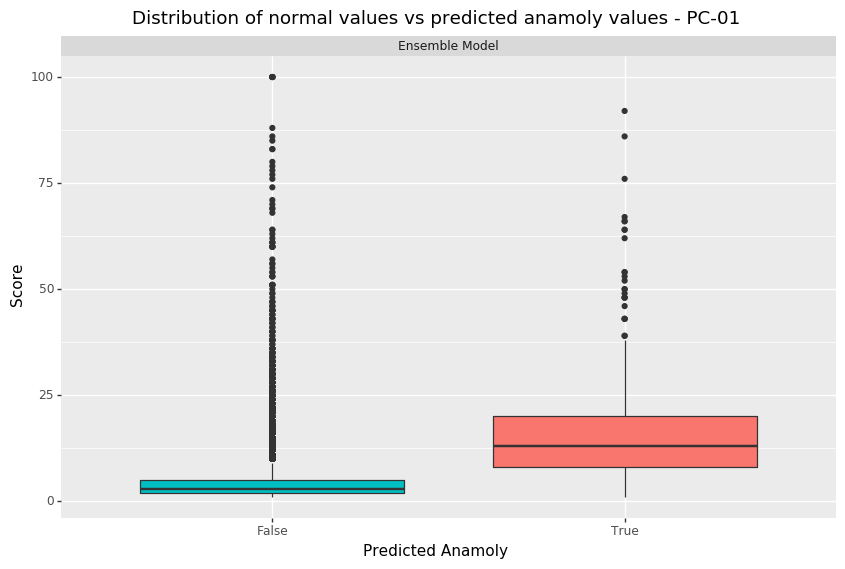

<ggplot: (8771810960161)>

In [25]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),     
        aes(x = 'outlier',
            y = 'score',
            fill = 'outlier'))
 + ggtitle("Distribution of normal values vs predicted anamoly values - PC-01")
 + ylab("Score")
 + xlab("Predicted Anamoly")
 + labs(fill = 'Predicted Anamoly')
 + geom_boxplot(show_legend = False)
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + facet_wrap('~model', nrow = 1)
)

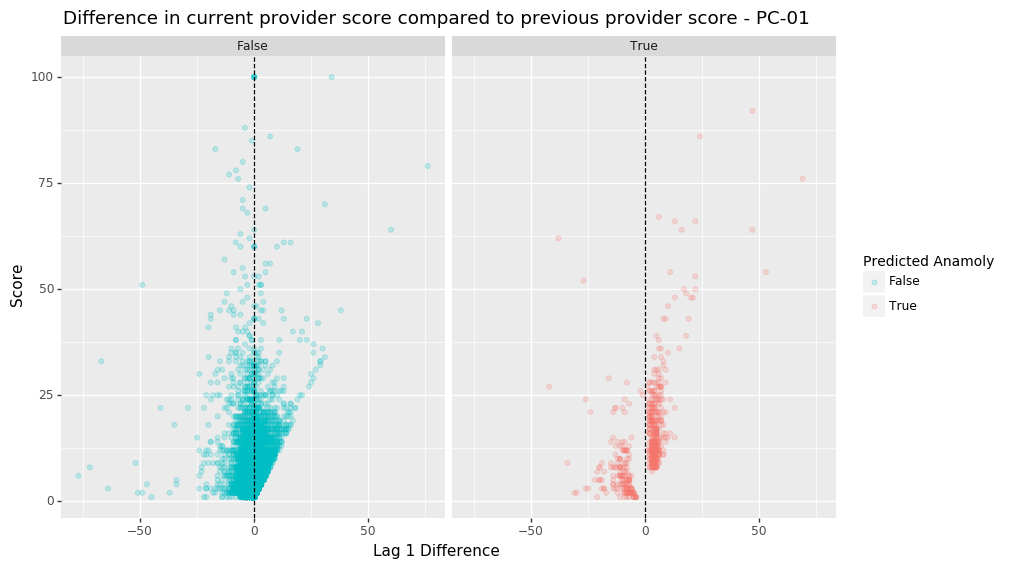

<ggplot: (8771810996689)>

In [26]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),     
        aes(x = 'lag_diff', 
            y = 'score',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Difference in current provider score compared to previous provider score - PC-01")
 + xlab("Lag 1 Difference")
 + ylab("Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_point(alpha = 0.2)
 + geom_vline(xintercept = 0, linetype = 'dashed')
 + facet_wrap('~outlier')
 + theme(legend_title = element_text(size = 10))
)

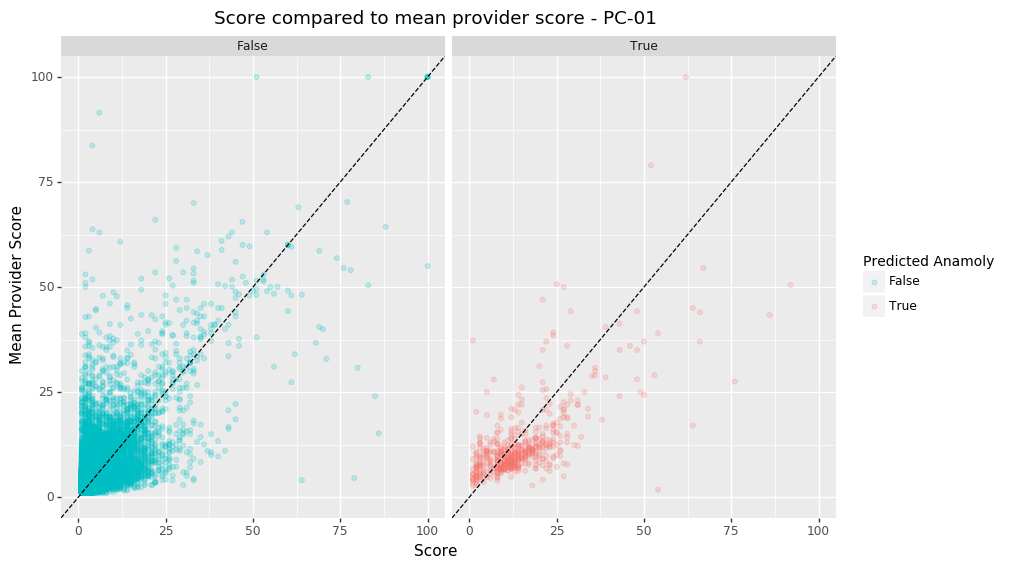

<ggplot: (8771810695985)>

In [27]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score - PC-01")
 + geom_point(size = 1.5, alpha = 0.2)
 + xlim(0,100)
 + ylim(0,100)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~outlier')
 + theme(legend_title = element_text(size = 10))
)

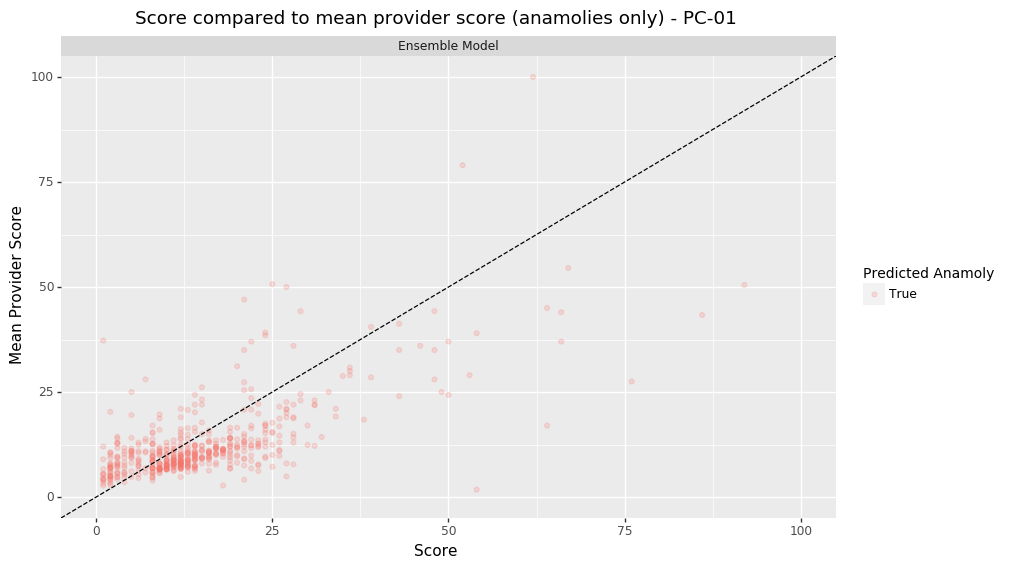

<ggplot: (8771810626469)>

In [28]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model" and outlier == True'),
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score (anamolies only) - PC-01")
 + geom_point(size = 1.5, alpha = 0.2)
 + xlim(0,100)
 + ylim(0,100)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~model', nrow = 1)
 + theme(legend_title = element_text(size = 10))
)

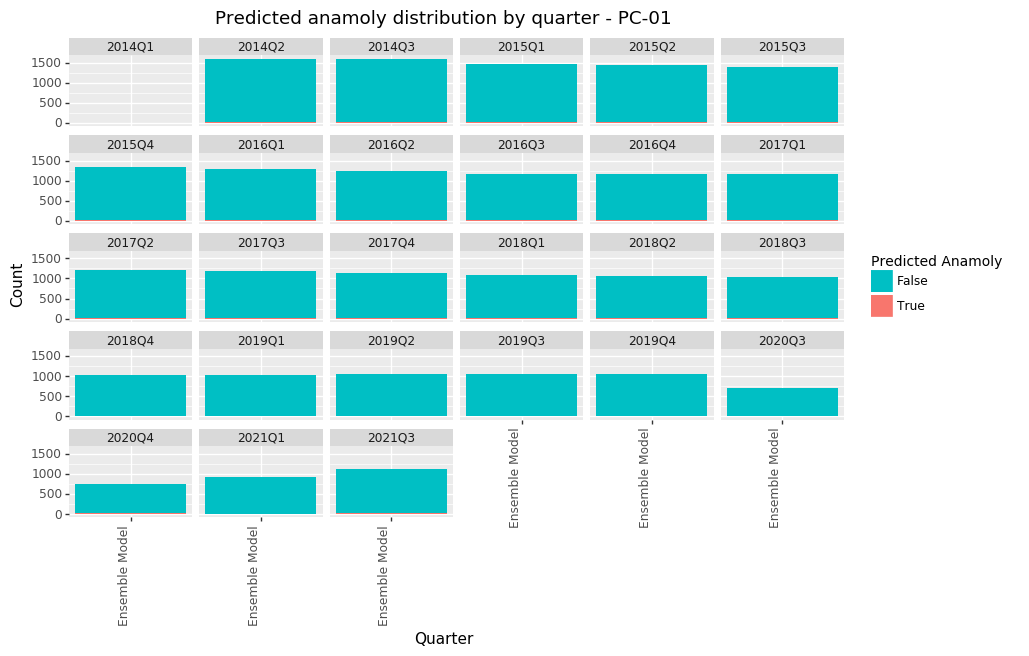

<ggplot: (8771810865189)>

In [29]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),     
        aes(x = 'model', fill = 'outlier'))
 + ggtitle("Predicted anamoly distribution by quarter - PC-01")
 + xlab("Quarter")
 + ylab("Count")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_bar()
 + theme(axis_text_x = element_text(rotation=90, hjust=1))
 + facet_wrap('y_quarter')
 + theme(legend_title = element_text(size = 10))
)

# Dynamic Time Warp Clustering

In [30]:
clusters = pd.read_csv("../../data/pc-01_clusters.csv")

In [31]:
clusters

,provider_id,year,quarter,cluster
0,100001,2017,1,C0
1,100001,2017,2,C0
2,100001,2017,3,C0
3,100001,2017,4,C0
4,100001,2018,1,C0
...,...,...,...,...
32870,90011,2015,3,C0
32871,90011,2015,4,C0
32872,90011,2016,1,C0
32873,90011,2016,2,C0


In [32]:
pc01_dataset['cluster'] = clusters['cluster']

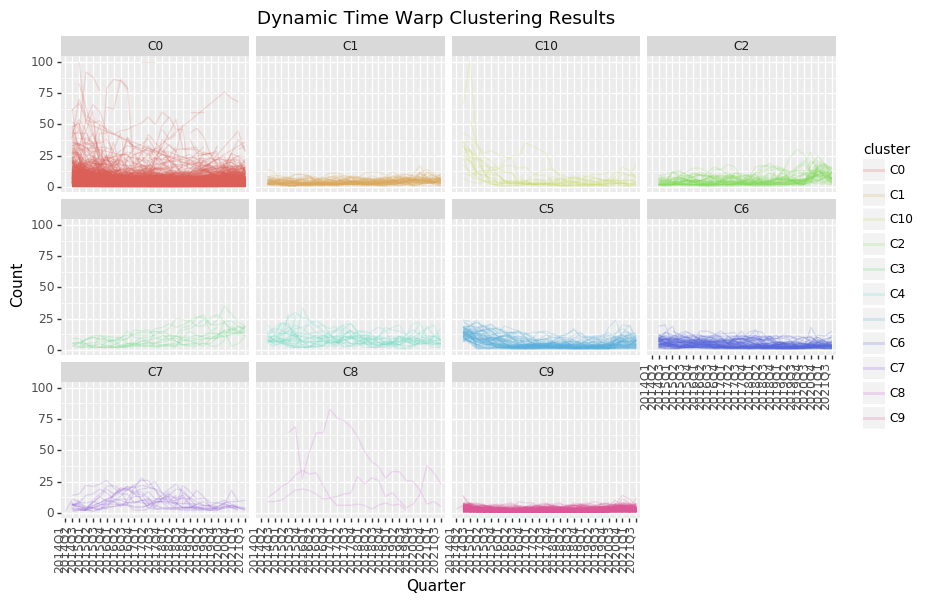

<ggplot: (8771792657805)>

In [33]:
plotnine.options.figure_size = (10,6)
(ggplot(pc01_dataset,     
        aes(x = 'y_quarter', 
            y = 'score',
            group = 'provider_id',
            color = 'cluster'))
 + ggtitle("Dynamic Time Warp Clustering Results")
 + xlab("Quarter")
 + ylab("Count")
 #+ labs(fill = 'Predicted Outlier', color = 'Predicted Outlier')
 #+ scale_color_manual(values = ["#00BFC4", "#F8766D"])
 #+ scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_line(alpha = 0.2)
 + theme(axis_text_x = element_text(rotation=90, hjust=1))
 + facet_wrap('cluster')
 + theme(legend_title = element_text(size = 10))
)

In [34]:
mae = np.sqrt(np.mean(abs(xgbr_pc01_dataset['score'] - xgbr_pc01_dataset['predicted_score'])))

pd.DataFrame({"RMSE":rmse, "MAE":mae}, index = [0])

NameError: name 'xgbr_pc01_dataset' is not defined